In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pearsonr,spearmanr,kendalltau
import json
import time

In [3]:
import openprotein
import openprotein.fasta as fasta

## Connect to the OpenProtein.AI API

In [5]:
with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(config['username'], config['password'])
print(session.backend)

Backend.PROD


## Load the chorismate mutase dataset

In [6]:
table_natural = pd.read_csv('data/chorismate_mutase_natural_sequences.csv')
table_variant = pd.read_csv('data/chorismate_mutase_variant_sequences.csv')

table_natural.head()

,No.,Species,Sequence,ID to EcCM,top ID,EDCA (rel. to EcCM),norm r.e.
0,1,Escherichia coli ...,-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPV...,1.00,0.93,0.00,1.00
1,2,Thermus thermophilus HB8 ...,---DERIQALRKEVDRVNREILRLLSERGRLVQEIGRLQTELGLPH...,0.26,0.89,28.62,-0.06
2,3,Pseudomonas aeruginosa UCBPP-PA14 ...,PEDCTGLADIREAIDQIDLDIVQALGRRMDYVKAASRFKANEA-AI...,0.20,0.71,-4.19,0.04
3,4,Enterobacter cloacae subsp. dissolvens SDM ...,-TPENPLLDLRVKISALDEKLLALLAERRALAIEVGKAKLDSHRPV...,0.93,0.93,8.57,0.65
4,5,Thermus aquaticus Y51MC23 ...,---DERIQALRREVDRVNRELLRLLSERGRLVQEIGRIQTELGLPH...,0.28,0.89,18.42,-0.08


In [7]:
table_variant.head()

,No.,T,reg. value,Sequence,ID to EcCM,top ID,EDCA (rel. to EcCM),norm r.e.
0,1131,0.33,0.01,--TDNPLLALRERISALDLKLLALLAERRALALEVARTKLASHRPI...,0.78,0.82,-16.37,0.85
1,1132,0.33,0.01,LLVGLFFSTTALAAAIPSEDVASLINQRLSYMKDVAGYKANNHLAI...,0.14,0.84,-0.39,0.04
2,1133,0.33,0.01,PEDCEGLADIRRGIDALDREIVQILGRRLGYVKAASQFKPSEQ--I...,0.20,0.73,-3.03,-0.02
3,1134,0.33,0.01,PAAREELLELRGSIDNIDAALVHLLAERFKCTQRVGRLKARHGLPP...,0.30,0.81,-9.73,-0.11
4,1135,0.33,0.01,----KKLEEYRKEIDEIDKEIIKLFEKRMDVVLKVIEYKKKNNMPI...,0.18,0.65,0.70,0.88


Natural SpearmanrResult(correlation=0.035330109128214444, pvalue=0.23534819924369454)
Variants SpearmanrResult(correlation=-0.409259087679051, pvalue=2.2790178256876762e-66)


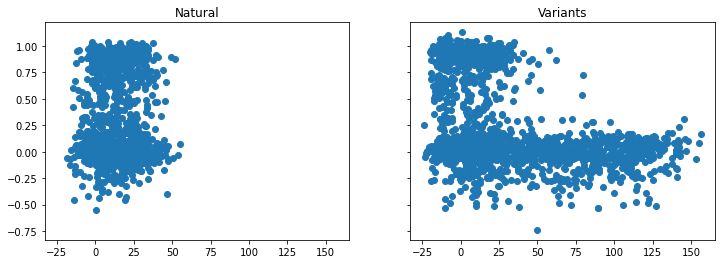

In [26]:
_, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
axs[0].scatter(table_natural['EDCA (rel. to EcCM)'].values, table_natural['norm r.e.'].values)
axs[0].set_title('Natural')
axs[1].scatter(table_variant['EDCA (rel. to EcCM)'].values, table_variant['norm r.e.'].values)
axs[1].set_title('Variants')

print('Natural', spearmanr(table_natural['EDCA (rel. to EcCM)'].values, table_natural['norm r.e.'].values))
print('Variants', spearmanr(table_variant['EDCA (rel. to EcCM)'].values, table_variant['norm r.e.'].values))

All SpearmanrResult(correlation=-0.2746346565247013, pvalue=9.571166707058114e-49)


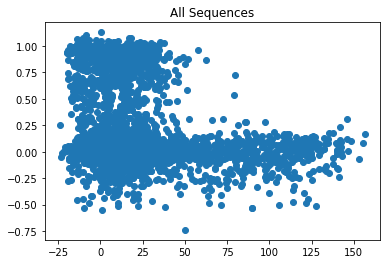

In [27]:
x = np.concatenate([
    table_natural['EDCA (rel. to EcCM)'].values,
    table_variant['EDCA (rel. to EcCM)'].values,
])
y = np.concatenate([
    table_natural['norm r.e.'].values,
    table_variant['norm r.e.'].values,
])
plt.scatter(x, y)
plt.title('All Sequences')

print('All', spearmanr(x, y))

### Use EcCM (E. coli chorismate mutase) as the seed sequence

In [8]:
seed = table_natural.iloc[0]['Sequence']
seed = seed.replace('-', '')
seed

'TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH'

## Rank the natural and variant sequences

In [9]:
msa = session.prots2prot.create_msa(seed.encode())
print(msa)

prompt = session.prots2prot.sample_prompt(msa, num_ensemble_prompts=3, random_seed=42)
print(prompt)

status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='62c52db6-3ae2-4c90-9c14-533162a29dd1' job_type='workflow/align/align' created_date=datetime.datetime(2023, 5, 2, 10, 53, 8, 791528) start_date=None end_date=datetime.datetime(2023, 5, 2, 10, 53, 8, 812409) prerequisite_job_id=None progress_message=None progress_count=None msa_id='62c52db6-3ae2-4c90-9c14-533162a29dd1'
status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='99bdc24a-95e4-4bb9-995e-9ef10a6ca5ba' job_type='workflow/align/prompt' created_date=datetime.datetime(2023, 5, 2, 10, 53, 9, 162413) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_count=None prompt_id='99bdc24a-95e4-4bb9-995e-9ef10a6ca5ba'


In [10]:
sequences = table_natural['Sequence'].apply(lambda s: s.replace('-', '').encode()).values
print(sequences.shape)

future_natural = session.prots2prot.score(prompt, sequences)
print(future_natural.job)

(1130,)
status=<JobStatus.PENDING: 'PENDING'> job_id='064cdcc3-a76c-4585-9813-264b4e31b44e' job_type='/workflow/prots2prot' created_date=datetime.datetime(2023, 5, 2, 10, 54, 17, 851821) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_count=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None


In [29]:
sequences = table_variant['Sequence'].apply(lambda s: s.replace('-', '').encode()).values
print(sequences.shape)

future_variant = session.prots2prot.score(prompt, sequences)
print(future_variant.job)

(1618,)
status=<JobStatus.PENDING: 'PENDING'> job_id='956ee5a7-30c1-4272-8396-78f2f05f923a' job_type='/workflow/prots2prot' created_date=datetime.datetime(2023, 5, 2, 11, 35, 24, 779521) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_count=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None


In [30]:
results_natural = future_natural.wait(verbose=True)
results_variant = future_variant.wait(verbose=True)

print(len(results_natural), len(results_variant))

1it [00:00,  2.54it/s, status=SUCCESS]
112it [05:18,  2.84s/it, status=SUCCESS]


1130 1618


In [31]:
scores_natural = np.array([r.score for r in results_natural])
scores_variant = np.array([r.score for r in results_variant])
scores_natural.shape, scores_variant.shape

((1130, 3), (1618, 3))

In [32]:
score_natural = scores_natural.mean(axis=1)
score_variant = scores_variant.mean(axis=1)
score_natural.shape, scores_variant.shape

((1130,), (1618, 3))

Natural SpearmanrResult(correlation=0.3482140322743968, pvalue=1.4801709792817108e-33)
Variant SpearmanrResult(correlation=0.4967878271499042, pvalue=1.3965664362656567e-101)


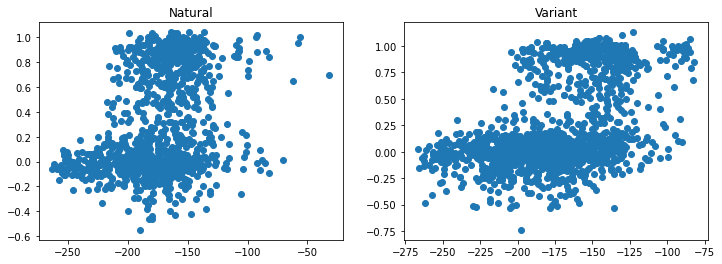

In [33]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

x = score_natural
y = table_natural['norm r.e.'].values
axs[0].scatter(x, y)
axs[0].set_title('Natural')
print('Natural', spearmanr(x, y))

x = score_variant
y = table_variant['norm r.e.'].values
axs[1].scatter(x, y)
axs[1].set_title('Variant')
print('Variant', spearmanr(x, y))

All SpearmanrResult(correlation=0.44488113678989877, pvalue=1.059566612055129e-133)


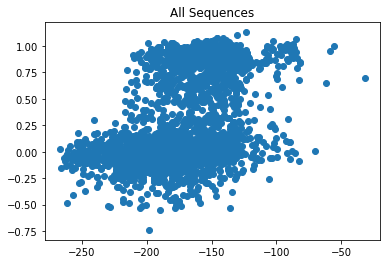

In [34]:
x = np.concatenate([
    score_natural,
    score_variant,
])
y = np.concatenate([
    table_natural['norm r.e.'].values,
    table_variant['norm r.e.'].values,
])
plt.scatter(x, y)
plt.title('All Sequences')

print('All', spearmanr(x, y))

## What if we use the functional natural sequences as the prompt?

In [35]:
table_nat_functional = table_natural.loc[table_natural['norm r.e.'] >= 0.45]
print(table_nat_functional.shape)
table_nat_functional.head()

(407, 7)


,No.,Species,Sequence,ID to EcCM,top ID,EDCA (rel. to EcCM),norm r.e.
0,1,Escherichia coli ...,-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPV...,1.00,0.93,0.00,1.00
3,4,Enterobacter cloacae subsp. dissolvens SDM ...,-TPENPLLDLRVKISALDEKLLALLAERRALAIEVGKAKLDSHRPV...,0.93,0.93,8.57,0.65
5,6,Salmonella enterica subsp. enterica serovar Sa...,-TSENPLLALRDKISALDEELLALLAKRRALAIEVGQAKLLSHRPV...,0.90,0.89,9.83,0.70
6,7,Cronobacter sakazakii ATCC BAA-894 ...,-TAENPLLALRDKISALDEQLLALLAQRRALAVEVGKAKLATHRPV...,0.91,0.90,6.42,0.95
8,9,Erwinia billingiae Eb661 ...,-TPENPLLGLRDKISALDEQLLNMLAQRRALAIEVATAKMATHRPI...,0.80,0.85,26.25,0.84


In [36]:
from io import BytesIO

msa_const = session.prots2prot.upload_msa(BytesIO(b'\n'.join(table_nat_functional['Sequence'].apply(lambda s: s.encode()))))
print(msa_const)

prompt_const = session.prots2prot.sample_prompt(msa_const, num_ensemble_prompts=3, random_seed=42)
print(prompt_const)

status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='b35fa25d-64e9-46e5-9b02-5cce2c1a6751' job_type='workflow/align/align' created_date=datetime.datetime(2023, 5, 2, 11, 48, 3, 691239) start_date=None end_date=datetime.datetime(2023, 5, 2, 11, 48, 3, 704917) prerequisite_job_id=None progress_message=None progress_count=None msa_id='b35fa25d-64e9-46e5-9b02-5cce2c1a6751'
status=<JobStatus.SUCCESS: 'SUCCESS'> job_id='44218875-e55a-4285-99cf-1a1c95584959' job_type='workflow/align/prompt' created_date=datetime.datetime(2023, 5, 2, 11, 48, 4, 139727) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_count=None prompt_id='44218875-e55a-4285-99cf-1a1c95584959'


In [37]:
sequences = table_variant['Sequence'].apply(lambda s: s.replace('-', '').encode()).values
print(sequences.shape)

future_variant_const = session.prots2prot.score(prompt_const, sequences)
print(future_variant_const.job)

(1618,)
status=<JobStatus.PENDING: 'PENDING'> job_id='29bc8f97-a508-49c3-8b97-a3b3150a4270' job_type='/workflow/prots2prot' created_date=datetime.datetime(2023, 5, 2, 11, 49, 5, 893006) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_count=None parent_id=None s3prefix=None page_size=None page_offset=None num_rows=None result=None n_completed=None


In [38]:
results_variant_const = future_variant_const.wait(verbose=True)
print(len(results_variant_const))

118it [05:36,  2.85s/it, status=SUCCESS]


1618


In [39]:
scores_variant_const = np.array([r.score for r in results_variant_const])
score_variant_const = scores_variant_const.mean(axis=1)
scores_variant_const.shape, score_variant_const.shape

((1618, 3), (1618,))

Variant SpearmanrResult(correlation=0.5441387133550285, pvalue=2.2734091856501145e-125)


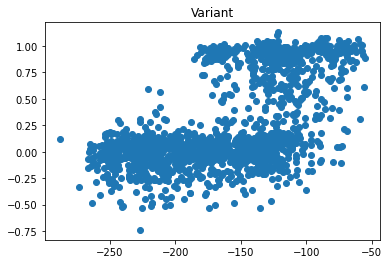

In [40]:
_, ax = plt.subplots(figsize=(6, 4))

x = score_variant_const
y = table_variant['norm r.e.'].values
ax.scatter(x, y)
ax.set_title('Variant')
print('Variant', spearmanr(x, y))

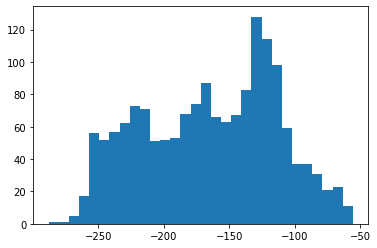

In [46]:
_ = plt.hist(score_variant_const, bins=30)

## Use this prompt to generate some new sequences

In [50]:
future_gen = session.prots2prot.generate(prompt_const, num_samples=1000, topp=0.9)
print(future_gen.job)

status=<JobStatus.PENDING: 'PENDING'> job_id='51a2d578-fff2-4d68-b9a8-30557285dd60' job_type='/workflow/prots2prot/generate' created_date=datetime.datetime(2023, 5, 2, 13, 26, 16, 71719) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_count=None


In [51]:
results_gen = future_gen.wait(verbose=True)
print(len(results_gen))

873it [41:54,  2.88s/it, status=SUCCESS]


1000


In [52]:
sample_names = np.array([s.name for s in results_gen])
sample_sequences = np.array([s.sequence for s in results_gen])
sample_scores = np.array([s.score for s in results_gen]).mean(axis=1)
order = np.argsort(-sample_scores)
for i in order[:10]:
    print(sample_names[i], sample_scores[i], sample_sequences[i].decode(), sep='\t')

generated-sequence-267	-13.368366877237955	SSEKKLEEIRKRISEIDEQLITLIAERTGFAPEIASLKNSLGASVTDSKREQDICEQTRILCEECIECSVALKIIKILMEYNKEVQAEFFRKV
generated-sequence-555	-13.830108960469564	QPNERLNDLRRAVDHLDDQLLDILQERFAVIDQIGAHKREHHLSVFQSDRWKDVMESRTQKGVQNLSEKFMKELLYSIHEESVKRQEKQLRES
generated-sequence-586	-13.896090507507324	QPNERLNDLRRAVDHLDDQLLDILQERFAVIDQIGAHKREHHLSVFQSDRWKDVMESRTQKGVQNLSEKFMKELLYSIHEESVKRQEKQLKES
generated-sequence-260	-17.756848017374676	LNDLRRAVDHLDDQLLDILQERFAVIDQIGAHKREHHLSVFQSDRWKDVMESRTQKGVQNLSEKFMKELLYSIHEESVKRQERQLRES
generated-sequence-379	-17.915011088053387	SEKRLEEIRKRISEIDEQLITLIAERTGFAPEIASLKNSLGASVTDSKREQDICEQTRILCEECIECSVALKIIKILMEYNKEVQAEFFRKL
generated-sequence-222	-18.62750752766927	NKNLDLGELRSQLDEIDGQLVRLFEQRMKICADVAEYKIETGKAVYDGERERQKLEAVGAMAHGFNSQAVRELFSQLMTVSRKRQYQLLARH
generated-sequence-513	-27.403642654418945	SSDAKLEEIRKRISEIDEQLIALIAERTGFAPEIASLKNSLGASVTDSKREQDICEQTRILCEECIECSVALKIIKILMEYNKEVQAEFFRKV
generated-sequence-177	-29.403276761372883	TENPLL

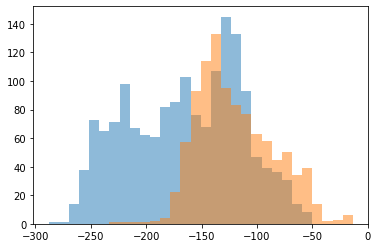

In [54]:
#mi = min(np.min(score_variant_const), np.min(sample_scores))
mi = np.min(score_variant_const)
ma = max(np.max(score_variant_const), np.max(sample_scores))
bins = np.linspace(mi, ma, 31)

_ = plt.hist(score_variant_const, bins=bins, alpha=0.5)
_ = plt.hist(sample_scores, bins=bins, alpha=0.5)

#### Compare these with the seed sequence used to build the prompt

In [55]:
from Bio import pairwise2
import Bio.Align.substitution_matrices
blosum62 = Bio.Align.substitution_matrices.load('blosum62')

In [56]:
for i in order[:10]:
    x = sample_sequences[i].decode()
    print(f'>{sample_names[i]} {sample_scores[i]}')
    for a in pairwise2.align.globalds(seed, x, blosum62, -11, -1):
        print(pairwise2.format_alignment(*a))
        break

>generated-sequence-267 -13.368366877237955
TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH
.||..|...|..||..||.|..|.|||...|.|....|......|.|..||.|..|....|.. ................|.....|.......
SSEKKLEEIRKRISEIDEQLITLIAERTGFAPEIASLKNSLGASVTDSKREQDICEQTRILCE-ECIECSVALKIIKILMEYNKEVQAEFFRKV
  Score=89

>generated-sequence-555 -13.830108960469564
TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH
.....|..||.....||..||..|.||.......|..|...|..|...||..|..|.....| ...|.......|...|.|.||..|...|...
QPNERLNDLRRAVDHLDDQLLDILQERFAVIDQIGAHKREHHLSVFQSDRWKDVMESRTQKG-VQNLSEKFMKELLYSIHEESVKRQEKQLRES
  Score=84

>generated-sequence-586 -13.896090507507324
TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH
.....|..||.....||..||..|.||.......|..|...|..|...||..|..|.....| ...|.......|...|.|.||..|...|...
QPNERLNDLRRAVDHLDDQLLDILQERFAVIDQIGAHKREHHLSVFQSDRWKDVMESRTQKG-VQNLSEKFMKELLYSIHEESV